In [1]:
# Import Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Machine learning modules

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# Read clinical trials data 
file_path = 'C:./data/vaccine_trials.csv'
vaccine_trials = pd.read_csv(file_path, index_col = 0)

# Filter completed studies
trials_filtered = vaccine_trials[vaccine_trials['OverallStatus'] == 'Completed']
trials_filtered

# Drop 'Rank' column
trials_filtered.drop('Rank', axis=1, inplace=True)

# Display the DataFrame
trials_filtered

c:\Users\Bruna Los\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,NCTId,Phase,Condition,EnrollmentCount,OverallStatus
0,NCT00478816,Phase 2,Prophylaxis of Avian Influenza Vaccine,58,Completed
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed
3,NCT03057483,NaN,Influenza Vaccines,533,Completed
4,NCT00735410,Phase 3,"Seasonal Influenza, Vaccine",134,Completed
5,NCT00103116,Phase 2,Lung Cancer,32,Completed
...,...,...,...,...,...
994,NCT00430521,Phase 2,Influenza|Influenza Vaccines,512,Completed
995,NCT01062477,Phase 3,Diphtheria|Tetanus|Pertussis|Haemophilus Influ...,1056,Completed
996,NCT02236052,Phase 2,Virus Diseases|RNA Virus Infections|Respirator...,450,Completed
997,NCT03357276,Phase 1|Phase 2,Metastatic Colorectal Cancer|Reaction - Mixed ...,30,Completed



### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download)
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [4]:
# Read drop_withdrawals file from AACT database
file_path = 'C:./data/drop_withdrawal.txt'

# select only the id, nct_id, period, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[0,1,4,5,6])

# Rename nct_id column to NCTId 
drop_withdrawals = drop_withdrawals.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
drop_withdrawals

,id,NCTId,period,reason,count
0,41463481,NCT01443026,Overall Study,Physician Decision,1.0
1,41463482,NCT01443026,Overall Study,Physician Decision,0.0
2,41463483,NCT01443026,Overall Study,Death,0.0
3,41463484,NCT01443026,Overall Study,Death,1.0
4,41463485,NCT01443026,Overall Study,Withdrawal by Subject,0.0
...,...,...,...,...,...
463552,41835055,NCT02333331,Overall Study,Protocol Deviation,1.0
463553,41835056,NCT02333331,Overall Study,Patient/Guardian Decision,1.0
463554,41835057,NCT02333331,Overall Study,Patient/Guardian Decision,2.0
463555,41835058,NCT02333331,Overall Study,Patient/Guardian Decision,9.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [5]:
# Read milestones file from AACT database
file_path = 'C:./data/milestones.txt'

# select only the id, nct_id, period, reason, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[0,1,4,5,7])

# Rename nct_id column to NCTId 
milestones = milestones.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
milestones

,id,NCTId,title,period,count
0,59334265,NCT02829723,STARTED,Overall Study,5.0
1,59334266,NCT02829723,STARTED,Overall Study,7.0
2,58934891,NCT03907579,STARTED,Overall Study,100.0
3,59201010,NCT03074500,STARTED,Overall Study,11.0
4,59201011,NCT03074500,STARTED,Overall Study,11.0
...,...,...,...,...,...
664874,59334260,NCT03091192,NOT COMPLETED,Overall Study,33.0
664875,59334261,NCT03091192,NOT COMPLETED,Overall Study,27.0
664876,59334262,NCT03087760,STARTED,Overall Study,22.0
664877,59334263,NCT03087760,COMPLETED,Overall Study,3.0


#### Exploring the data

In [6]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
trials_drop = pd.merge(trials_filtered, drop_withdrawals, on='NCTId')
trials_drop

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,id,period,reason,count
0,NCT02915302,Phase 4,Influenza,1950,Completed,41723417,Overall Study,Adverse Event,3.0
1,NCT02915302,Phase 4,Influenza,1950,Completed,41723418,Overall Study,Adverse Event,0.0
2,NCT02915302,Phase 4,Influenza,1950,Completed,41723419,Overall Study,Protocol Violation,20.0
3,NCT02915302,Phase 4,Influenza,1950,Completed,41723420,Overall Study,Protocol Violation,27.0
4,NCT02915302,Phase 4,Influenza,1950,Completed,41723421,Overall Study,Lost to Follow-up,19.0
...,...,...,...,...,...,...,...,...,...
2804,NCT00430521,Phase 2,Influenza|Influenza Vaccines,512,Completed,41664471,Overall Study,Withdrawal by Subject,2.0
2805,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667160,Overall Study,"Adverse event, non-fatal",1.0
2806,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667161,Overall Study,"Adverse event, non-fatal",0.0
2807,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667162,Overall Study,Withdrawal by Subject,4.0


In [7]:
# Print information about the DataFrame
trials_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2809 entries, 0 to 2808
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NCTId            2809 non-null   object 
 1   Phase            2800 non-null   object 
 2   Condition        2809 non-null   object 
 3   EnrollmentCount  2809 non-null   int64  
 4   OverallStatus    2809 non-null   object 
 5   id               2809 non-null   int64  
 6   period           2809 non-null   object 
 7   reason           2809 non-null   object 
 8   count            2809 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 219.5+ KB


In [8]:
# Count unique events per column
unique_counts = trials_drop.nunique()
unique_counts

NCTId               218
Phase                 7
Condition           123
EnrollmentCount     196
OverallStatus         1
id                 2809
period               26
reason              156
count               106
dtype: int64

In [9]:
# Check for duplicates
duplicates = trials_drop.duplicated()
print(duplicates.value_counts())

False    2809
dtype: int64


In [10]:
# Count NaN values per column
nan_counts = trials_drop.isna().sum()
nan_counts

NCTId              0
Phase              9
Condition          0
EnrollmentCount    0
OverallStatus      0
id                 0
period             0
reason             0
count              0
dtype: int64

In [11]:
# Summary statistics

#trials_drop.describe(include = 'all')
trials_drop.describe()

,EnrollmentCount,id,count
count,2809.000000,2.809000e+03,2809.000000
mean,2368.951228,4.166494e+07,10.702029
std,6864.402191,1.239859e+05,107.464779
min,1.000000,4.146058e+07,0.000000
25%,449.000000,4.156007e+07,0.000000
50%,777.000000,4.165647e+07,1.000000
75%,1893.000000,4.173069e+07,3.000000
max,84496.000000,4.192300e+07,3006.000000


In [12]:
# Group by 'NCTId' and count occurrences of each 'reason'
reason_counts = trials_drop.groupby(['NCTId', 'reason']).size().reset_index(name='count')
reason_counts

,NCTId,reason,count
0,NCT00101166,progressive disease,1
1,NCT00130793,Lost to Follow-up,2
2,NCT00130793,Withdrew consent,2
3,NCT00244374,Declined to participate in cohort,5
4,NCT00244374,Did not complete baseline procedures,5
...,...,...,...
783,NCT05091307,Other,4
784,NCT05091307,Physician Decision,4
785,NCT05091307,Protocol Violation,4
786,NCT05091307,Randomized but not vaccinated,4


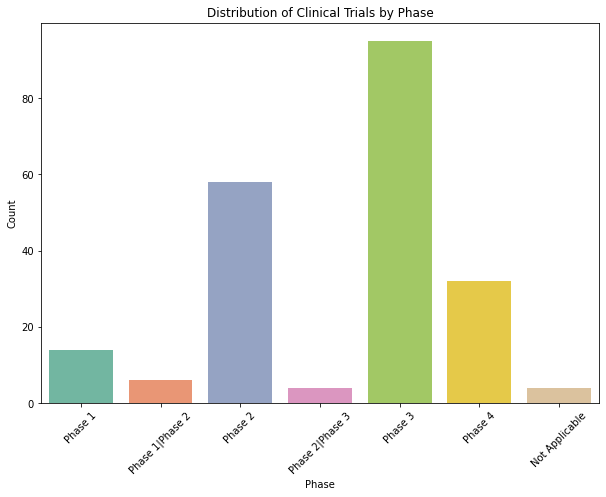

In [13]:
# Plot the distribution of clinical trials by phase

# Select only 'NCTId' and 'Phase' columns
phase_df = trials_drop[['NCTId', 'Phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Phase 1', 'Phase 1|Phase 2','Phase 2', 'Phase 2|Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='Phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [14]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
trials_participants_status = pd.merge(trials_filtered, milestones, on='NCTId')
trials_participants_status

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,id,title,period,count
0,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,59224103,STARTED,Overall Study,32.0
1,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,59224104,COMPLETED,Overall Study,31.0
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed,59224105,NOT COMPLETED,Overall Study,1.0
3,NCT00103116,Phase 2,Lung Cancer,32,Completed,58955224,STARTED,Overall Study,32.0
4,NCT00103116,Phase 2,Lung Cancer,32,Completed,58955225,COMPLETED,Overall Study,32.0
...,...,...,...,...,...,...,...,...,...
2965,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154345,STARTED,Overall Study,89.0
2966,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154346,COMPLETED,Overall Study,176.0
2967,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154347,COMPLETED,Overall Study,86.0
2968,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154348,NOT COMPLETED,Overall Study,5.0


In [15]:
# Count unique events per column
unique_counts = trials_participants_status.nunique()
unique_counts

NCTId               287
Phase                 8
Condition           158
EnrollmentCount     230
OverallStatus         1
id                 2970
title                52
period               35
count               659
dtype: int64

In [16]:
# Check for duplicates
duplicates = trials_participants_status.duplicated()
print(duplicates.value_counts())

False    2970
dtype: int64


In [17]:
# Count NaN values per column
nan_counts = trials_participants_status.isna().sum()
nan_counts

NCTId               0
Phase              45
Condition           0
EnrollmentCount     0
OverallStatus       0
id                  0
title               0
period              0
count               0
dtype: int64

In [18]:
# Inspect only one NCT study

one_study = trials_participants_status[trials_participants_status['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,id,title,period,count
2964,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154344,STARTED,Overall Study,181.0
2965,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154345,STARTED,Overall Study,89.0
2966,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154346,COMPLETED,Overall Study,176.0
2967,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154347,COMPLETED,Overall Study,86.0
2968,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154348,NOT COMPLETED,Overall Study,5.0
2969,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,59154349,NOT COMPLETED,Overall Study,3.0


In [19]:
one_study = trials_drop[trials_drop['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,id,period,reason,count
2805,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667160,Overall Study,"Adverse event, non-fatal",1.0
2806,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667161,Overall Study,"Adverse event, non-fatal",0.0
2807,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667162,Overall Study,Withdrawal by Subject,4.0
2808,NCT00309166,Phase 2,"Infections, Papillomavirus",270,Completed,41667163,Overall Study,Withdrawal by Subject,3.0


#### Analysis

In [40]:
# define function to sum the values in the 'count' column
def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [62]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


- Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [58]:
# use the 'sum_count' function to select the 'reason' and 'count' columns and sum the values in the 'count' column

reason_sum = sum_count(trials_drop, 'reason', 'count')
reason_sum.head()

,reason,TotalSum
0,ADMINISTRATIVE REASON,73.0
1,AE or Death,6.0
2,Administrative Reason,121.0
3,Administrative Reasons,4.0
4,Administrative reason,43.0


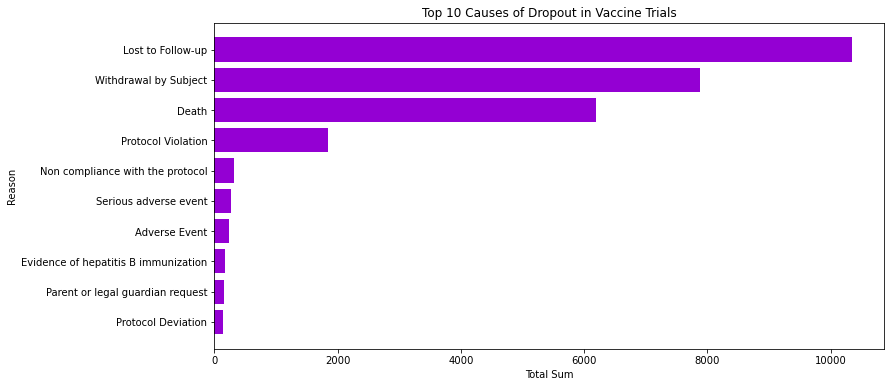

In [63]:
# Plot
dataframe = reason_sum
x_column = 'reason'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


- Determine the prevalence of vaccines utilized as interventions in clinical trials by identifying the most frequently administered ones.

In [24]:
# Select only 'NCTId' and 'Condition' columns
condition_df = trials_drop[['NCTId', 'Condition']]
condition_df = condition_df.drop_duplicates()
condition_df

,NCTId,Condition
0,NCT02915302,Influenza
10,NCT00560066,Seasonal Influenza|Vaccine
22,NCT02842866,Meningitis|Meningococcal Meningitis|Meningococ...
30,NCT02752906,Meningitis|Meningococcal Meningitis|Meningococ...
36,NCT00306527,Influenza
...,...,...
2681,NCT04811664,SARS-CoV-2 Infection
2705,NCT01339923,Meningococcal Disease|Meningococcal Meningitis
2747,NCT02285998,Influenza
2757,NCT00430521,Influenza|Influenza Vaccines


In [25]:
# Calculate the total count for each condition
condition_counts = condition_df['Condition'].value_counts().reset_index()

# Rename the columns for clarity
condition_counts.columns = ['Condition', 'TotalCount']

# Display the resulting DataFrame
condition_counts.head()

,Condition,TotalCount
0,Influenza,36
1,Meningococcal Disease,9
2,"Vaccines, Pneumococcal",8
3,Meningitis|Meningococcal Meningitis|Meningococ...,7
4,Meningococcal Disease|Meningococcal Meningitis,6


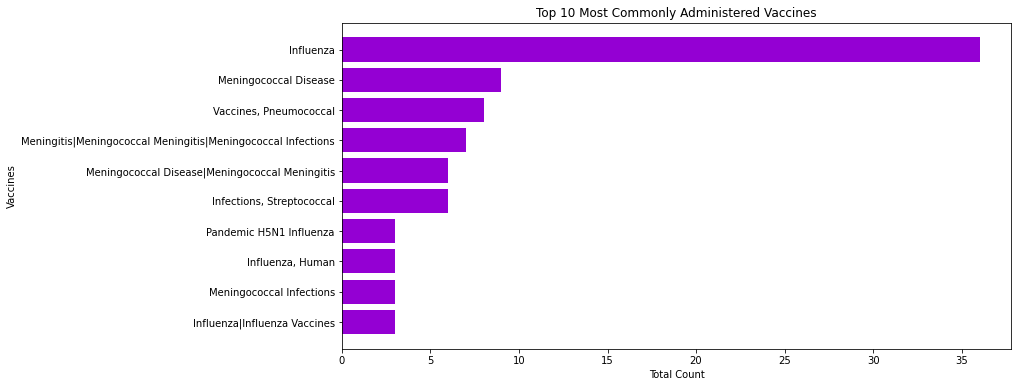

In [64]:
# Plot

dataframe = condition_counts
x_column = 'Condition'
y_column = 'TotalCount'
title = 'Top 10 Most Commonly Administered Vaccines'
xlabel = 'Total Count'
ylabel = 'Vaccines'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [50]:
# use the 'sum_count' function to select the 'title' and 'count' columns and sum the values in the 'count' column

status_sum = sum_count(trials_participants_status, 'title', 'count')
status_sum.head()

,title,TotalSum
0,Baseline Negative,1460.0
1,Baseline Negative With Outside Vaccination Cen...,1331.0
2,COMPLETED,438253.0
3,Did Not Start Treatment,1.0
4,Dose 1,1255.0


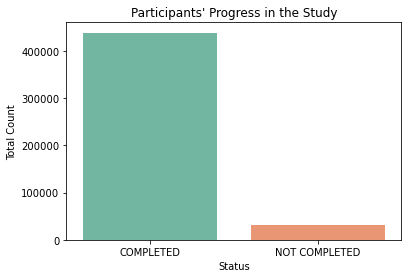

In [52]:
# Filter rows where the 'Title' column is either 'COMPLETED' or 'NOT COMPLETED'
status_filtered = status_sum[status_sum['title'].isin(['COMPLETED', 'NOT COMPLETED'])]

# Plot a barplot
sns.barplot(x='title', y='TotalSum', data=status_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total Count')
plt.show()


### Preprocess the data

In [ ]:
# Missing values

trials_drop.isnull().sum()

NCTId              0
Phase              9
Condition          0
EnrollmentCount    0
OverallStatus      0
id                 0
period             0
reason             0
count              0
dtype: int64

In [ ]:
# Select the variables for further analysis

cols = ['id', 'NCTId', 'reason', 'Condition']
df = trials_drop[cols].dropna()
df.shape 

(2809, 4)

In [ ]:
df.head()

,id,NCTId,reason,Condition
0,41723417,NCT02915302,Adverse Event,Influenza
1,41723418,NCT02915302,Adverse Event,Influenza
2,41723419,NCT02915302,Protocol Violation,Influenza
3,41723420,NCT02915302,Protocol Violation,Influenza
4,41723421,NCT02915302,Lost to Follow-up,Influenza


In [ ]:
# dummy variables
df = pd.get_dummies(df, columns=['reason', 'Condition'], prefix=['reason', 'Condition'])
df.head()

,id,NCTId,reason_ADMINISTRATIVE REASON,reason_AE or Death,reason_Administrative Reason,reason_Administrative Reasons,reason_Administrative reason,reason_Adverse Event,"reason_Adverse Event, non-fatal","reason_Adverse Event, not serious",...,Condition_Streptococcal Infections|Gram-Positive Bacterial Infections|Bacterial Infections,Condition_Streptococcal Infection|Gram-positive Bacterial Infection|Bacterial Infection,Condition_Tetanus|Diphtheria|Pertussis|Whooping Cough,Condition_Tularemia,Condition_Vaccine Response Impaired,"Condition_Vaccines, Pneumococcal","Condition_Vaccines, Pneumococcal Conjugate Vaccine",Condition_Virus Diseases|RNA Virus Infections|Respiratory Tract Diseases|Respiratory Tract Infections,Condition_Virus Diseases|RNA Virus Infections|Respiratory Tract Diseases|Respiratory Tract Infections|Influenza,Condition_West Nile Fever
0,41723417,NCT02915302,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,41723418,NCT02915302,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41723419,NCT02915302,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,41723420,NCT02915302,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41723421,NCT02915302,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
